In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2

import os
import time

In [2]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    #x_center, y_center, width, height = bbox#*416
    x_min,y_min,x_max,y_max=bbox
    #x_min = int(x_center-(width//2))
    #y_min = int(y_center-(height//2))
    #x_max = int(x_center+(width//2))
    #y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    #class_name = class_idx_to_name[class_id]
    #((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    #cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)

In [3]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,convert_bboxes_from_albumentations
)
import numpy as np

In [4]:
from albumentations import (RandomBrightness,HorizontalFlip,RandomBrightness,HueSaturationValue,Compose,BboxParams,ShiftScaleRotate,Equalize,Cutout)


In [5]:
image_feature_description = {
    'bboxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [6]:
np.random.random()

0.5137109125193053

## USING IMGAUG

In [7]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
#ia.seed(0)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2
import os

In [8]:
image_feature_description = {
    'bboxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'num_real_boxes':tf.io.FixedLenFeature([], tf.int64),
}

In [148]:
def real_data_augmentation(image,bboxes):
    
    formato = "yolo"
    boxes = []
    categories = []
    for i in bboxes:
        boxes.append(list(i))
        categories.append(0)
        
    policy = np.random.randint(3)
    
    annotations = {"image":image,"bboxes":boxes,'category_id': categories}
    
    print(policy)
    policy = 1
    if policy == 0:    
        aug = get_aug([ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=0, value=0,p=1),
                       Equalize(mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1)])
        result  = aug(**annotations)
        image = result["image"]
        bboxes = convert_bboxes_from_albumentations(result["bboxes"],target_format= formato,rows=416,cols=416,check_validity=True)

    elif policy == 1:
        random_image_size=np.random.random()
        aug = get_aug([ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=0, value=0,p=1),
                       Cutout(num_holes=1, max_h_size=int(random_image_size*120), max_w_size=int(random_image_size*120), fill_value=128, p=1)])
        result  = aug(**annotations)
        image = result["image"]
        bboxes = convert_bboxes_from_albumentations(result["bboxes"],target_format= formato,rows=416,cols=416,check_validity=True)

    elif policy ==2:
        aug = get_aug([HueSaturationValue(hue_shift_limit =0, val_shift_limit=0,always_apply = True)])
        result  = aug(**annotations)
        image = result["image"]
        bboxes = convert_bboxes_from_albumentations(result["bboxes"],target_format= formato,rows=416,cols=416,check_validity=True)    
   
    return [image,bboxes]


def get_iou_matrix_tf(box_arr1, box_arr2):
    
    box_arr1 = box_arr1 -tf.tile(box_arr1[:,:2],[1,2])
    #print(box_arr1)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    yA = tf.maximum(y11, tf.transpose(y21))
    xB = tf.minimum(x12, tf.transpose(x22))
    yB = tf.minimum(y12, tf.transpose(y22))
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    return iou,tf.argmax(iou,axis=1)#[:,tf.newaxis]


def fill_yolo_output(boxes,grid_size,num_anchors,which_anchor_box,which_anchor_box_index):
    #print(boxes.shape)
    #noobj_mask = tf.ones((1,grid_size*grid_size*num_anchors))
    #print(noobj_mask.shape)
    
    x_min,y_min,x_max,y_max =tf.split(boxes,4,axis=1)

    #Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
    width = x_max-x_min
    height = y_max-y_min
    x_global =x_min + tf.math.divide(x_max - x_min,2)
    y_global =y_min + tf.math.divide(y_max - y_min,2)
    
    
    x_min_anchor,y_min_anchor,x_max_anchor,y_max_anchor =tf.split(which_anchor_box,4,axis=1)
    
    width_anchor = x_max_anchor-x_min_anchor
    height_anchor = y_max_anchor-y_min_anchor
    x_global_anchor =x_min_anchor + tf.math.divide(x_max_anchor - x_min_anchor,2)
    y_global_anchor =y_min_anchor + tf.math.divide(y_max_anchor - y_min_anchor,2)   

    
    #print("el x original",x_global)
    #print("el y original",y_global)
    #print("el w original",width)
    #print("el h original",height)
    
    #porción de la imagen que hay en cada celda
    pixel_per_grid = tf.math.divide(1.,grid_size)
    #print(pixel_per_grid)
    
    #Obtenemos la coordenada de la celda donde están los boundingboxes
    offset_grid_x = x_global//pixel_per_grid
    offset_grid_y = y_global//pixel_per_grid
    
    #Obtenemos el el centro locacon referencia  al celda encontrada previamente
    x_local =tf.math.floormod(x_global,pixel_per_grid)
    y_local =tf.math.floormod(y_global,pixel_per_grid)
    #print(x_local,y_local)
    
    #Valores tx e ty del groudtruth
    tx = tf.math.log(x_local + 1e-07/(1-x_local))
    ty = tf.math.log(y_local+1e-07/(1-y_local))
    tw = tf.math.log(tf.math.divide(width+1e-07,width_anchor))
    th = tf.math.log(tf.math.divide(height+1e-07,height_anchor))
    
    #tobj = tf.ones((grid_size*grid_size*num_anchors,1))
    #tnoobj = tf.zeros((grid_size*grid_size*num_anchors,1))
    #print("Lo que la red debe predecir",tx.numpy(),ty.numpy(),tw.numpy(),th.numpy())
    
    #x_global = (offset_grid_x * pixel_per_grid) + tf.math.sigmoid(tx)
    #y_global = (offset_grid_y * pixel_per_grid) + tf.math.sigmoid(ty)
    #w = width_anchor*tf.math.exp(tw)
    #h = height_anchor*tf.math.exp(th)
    
    #print("obtnemos el x_real",x_global)
    #print("obtenemos el y_real",y_global)
    #print("obtenemos el w real",w)
    #print("obtenemos el h real",h)
    
    
    #print(which_anchor_box_index)
    residuo = tf.math.floormod(which_anchor_box_index,2)[:,tf.newaxis]
    coord = tf.cast(2*(offset_grid_y*grid_size + offset_grid_x),dtype=tf.int64)
    
    
    output_position = residuo+coord
    print("tipo de aoutput_positivon",output_position)
    
    print(output_position)
    
    tobj = tf.ones_like(tx)
    tnoobj = tf.zeros_like(tx)
    dense_shape = grid_size*grid_size*num_anchors
    tx_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tx[:,0], dense_shape=[dense_shape]))
    ty_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=ty[:,0], dense_shape=[dense_shape]))
    tw_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tw[:,0], dense_shape=[dense_shape]))
    th_vector = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=th[:,0], dense_shape=[dense_shape]))
    obj_mask = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tobj[:,0], dense_shape=[dense_shape]))
    noobj_mask = tf.sparse.reorder(tf.sparse.SparseTensor(indices=output_position, values=tnoobj[:,0], dense_shape=[dense_shape]))
    #obj_mask =tx_vector=ty_vector=tw_vector=th_vector = tf.zeros((1,grid_size*grid_size*num_anchors))
    
    tx_vector_dense = tf.sparse.to_dense(tx_vector, default_value=0, validate_indices=False, name="Dense_tx")
    ty_vector_dense = tf.sparse.to_dense(ty_vector, default_value=0, validate_indices=False, name="Dense_ty")
    tw_vector_dense = tf.sparse.to_dense(tw_vector, default_value=0, validate_indices=False, name="Dense_tw")
    th_vector_dense = tf.sparse.to_dense(th_vector, default_value=0, validate_indices=False, name="Dense_th")
    obj_mask_dense =  tf.sparse.to_dense(obj_mask, default_value=0, validate_indices=False, name="Dense_obj")
    noobj_mask_dense= tf.sparse.to_dense(noobj_mask, default_value=1, validate_indices=False, name="Dense_noobj")
    
    
    ##print(tx_vector.to_dense)
    #print(tf.sparse.to_dense(tx_vector, default_value=0, validate_indices=True, name=None))
    
    #tx_vector=tx_vector[[3,2],]
    #tx_vector[output_position[:,0]] = tx
    

    #print("coordenada de la salida:",output_position)
    
    return tx_vector_dense,ty_vector_dense,tw_vector_dense,th_vector_dense,obj_mask_dense,noobj_mask_dense

def build_targets(image,image_bboxes,num_real_boxes,anchor_boxes):
    
    images_bboxes_original = image_bboxes
    #Obtenemos los boduing boxes que son reales
    image_bboxes = image_bboxes[:num_real_boxes,:]
    #print("Bouding boxes de la imagen",image_bboxes)
    #Obteneos  la matriz de IoU , y el índice del anchor box que dió mejor resultado
    
    image_bboxes = tf.math.divide(image_bboxes,416)
    iou_matrix,which_anchor_box_index = get_iou_matrix_tf(image_bboxes,anchor_boxes)
    
    print(which_anchor_box_index)

    #Indices de los bouding boxes que irian en cada salida, index_best_ yolo nos dice que bouding boxes de la imagen van a la salida YOLO1,
    #porque su mejor IoU fue con los dos anchor boxes mas grandes
    index_best_yolo1 = tf.where(which_anchor_box_index>=2)[:,0]
    index_best_yolo2 = tf.where(which_anchor_box_index<2)[:,0]
    index_best_anchor_yolo1 = tf.gather(which_anchor_box_index,index_best_yolo1,axis=0)
    index_best_anchor_yolo2 = tf.gather(which_anchor_box_index,index_best_yolo2,axis=0)
    
    print(index_best_yolo1)
    print(index_best_anchor_yolo1)

    print(index_best_yolo2)
    print(index_best_anchor_yolo2)

    
    best_bboxes_yolo1 = tf.gather(image_bboxes,index_best_yolo1,axis =0)
    best_anchors_yolo1 = tf.gather(anchor_boxes,index_best_anchor_yolo1, axis =0) #LOs dos anchor boxes grandes corrsponden a YOLO
    best_bboxes_yolo2 = tf.gather(image_bboxes,index_best_yolo2,axis =0)
    best_anchors_yolo2 = tf.gather(anchor_boxes,index_best_anchor_yolo2, axis =0) #Los dos anchor boxes pequeños corresponden a YOLO2
    
    
    if best_anchors_yolo1.shape[0] !=0:
        tx_vector_yolo1,ty_vector_yolo1,tw_vector_yolo1,th_vector_yolo1,obj_mask_yolo1,noobj_mask_yolo1 = fill_yolo_output(best_bboxes_yolo1,13,2,best_anchors_yolo1,index_best_anchor_yolo1)
    else:
        tx_vector_yolo1=ty_vector_yolo1=tw_vector_yolo1=th_vector_yolo1=obj_mask_yolo1 = tf.zeros((1,grid_size*grid_size*num_anchors))
        noobj_mask_yolo1 = tf.ones((1,grid_size*grid_size*num_anchors))
    
    
    if best_anchors_yolo2.shape[0] != 0:
        tx_vector_yolo2,ty_vector_yolo2,tw_vector_yolo2,th_vector_yolo2,obj_mask_yolo2,noobj_mask_yolo2 = fill_yolo_output(best_bboxes_yolo2,26,2,best_anchors_yolo2,index_best_anchor_yolo2)
    else:

        tx_vector_yolo2=ty_vector_yolo2=tw_vector_yolo2=th_vector_yolo2=obj_mask_yolo2 = tf.zeros((1,grid_size*grid_size*num_anchors))
        noobj_mask_yolo2 = tf.ones((1,grid_size*grid_size*num_anchors))
        
    tx_vector = tf.concat([tx_vector_yolo1,tx_vector_yolo2],axis=0)
    ty_vector = tf.concat([ty_vector_yolo1,ty_vector_yolo2],axis=0)
    tw_vector = tf.concat([tw_vector_yolo1,tw_vector_yolo2],axis=0)
    th_vector = tf.concat([th_vector_yolo1,th_vector_yolo2],axis=0)
    obj_mask = tf.concat([obj_mask_yolo1,obj_mask_yolo2],axis=0)
    noobj_mask = tf.concat([noobj_mask_yolo1,noobj_mask_yolo2],axis=0)
    
    return image,images_bboxes_original,tx_vector,ty_vector,tw_vector,th_vector,obj_mask,noobj_mask


def imgaug_data_augmentation(image,bboxes,num_real_boxes):
    im_shape = image.shape
    bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes*416, shape=(416,416))
    
    policy = np.random.randint(5)
    
    #policy = 2
    if policy == 0:
        
        p = np.random.random()
        if p<0.6:
            aug = iaa.TranslateX(px=(-60, 60),cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
        p = np.random.random()
        if p<0.8:
            aug = iaa.HistogramEqualization()
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
    elif policy==1:
        
        p=np.random.random()
        if p<0.2:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
        
        p=np.random.random()
        if p<0.8:
            square_size = np.random.randint(48)
            aug = iaa.Cutout(nb_iterations=1, size=square_size/416, squared=True)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    elif policy==2:
        p=np.random.random()
        if p<=1:
            aug = iaa.ShearY(shear=(int(-0.06*416), int(0.06*416)), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
        p=np.random.random()
        if p<=1:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
            
    elif policy==3:
        p=np.random.random()
        if p<=0.6:    
            aug = iaa.Rotate(rotate=(-30, 30), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs_aug.remove_out_of_image().clip_out_of_image()
        
        p=np.random.random()
        if p>=1:
            aug = iaa.MultiplySaturation((0.54, 1.54))
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    bbs.remove_out_of_image()
    
    return image,np.clip(bbs.to_xyxy_array(np.float32),1,415),num_real_boxes
    
    
def preprocessing(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_jpeg(image_features['image_raw'],channels = 3)
    image = tf.cast(tf.image.resize(image,size=(416,416)), tf.uint8)
    bboxes =  tf.io.parse_tensor(image_features['bboxes'], out_type=tf.float32)
    
    num_real_boxes = image_features['num_real_boxes']
    return image,bboxes,num_real_boxes

    
@tf.function(input_signature=[tf.TensorSpec((416,416,3), tf.uint8),tf.TensorSpec((None,4), tf.float32),tf.TensorSpec((), tf.int64)]) 
def tf_numpy_albumentations_real(image,bboxes,num_real_boxes):
    
    boxes_shape = bboxes.shape
    im_shape = image.shape

    image,bboxes,num_real_boxes = tf.numpy_function(imgaug_data_augmentation,[image,bboxes,num_real_boxes],Tout =[tf.uint8,tf.float32,tf.int64])
 
    image.set_shape(im_shape)
    bboxes.set_shape(boxes_shape)
    
    #print("Imagen data type",image.dtype)
    #print("Bboxes data type",bboxes.dtype)   

    return image,bboxes,num_real_boxes

In [149]:
#USANDO TF.IMAGE MODULE
anchors =tf.constant(np.array([[0,0,0.015,0.037],[0,0,0.043,0.104],[0,0,0.11,0.278],[0,0,0.351,0.66]]),dtype=tf.float32)
os.chdir("/home/sergio/Documents/pedestrian_dataset_train_tfr")
filenames = os. listdir()
raw_image_dataset = tf.data.TFRecordDataset(filenames)
#.shuffle(70000)
parsed_image_dataset = raw_image_dataset.map(preprocessing,num_parallel_calls=8).map(tf_numpy_albumentations_real,num_parallel_calls=8).map(lambda x,y,z:build_targets(x,y,z,anchors),num_parallel_calls=8)

Tensor("ArgMax:0", shape=(None,), dtype=int64)
Tensor("strided_slice_2:0", shape=(None,), dtype=int64)
Tensor("GatherV2:0", shape=(None,), dtype=int64)
Tensor("strided_slice_3:0", shape=(None,), dtype=int64)
Tensor("GatherV2_1:0", shape=(None,), dtype=int64)
tipo de aoutput_positivon Tensor("add_16:0", shape=(None, 1), dtype=int64)
Tensor("add_16:0", shape=(None, 1), dtype=int64)
tipo de aoutput_positivon Tensor("add_26:0", shape=(None, 1), dtype=int64)
Tensor("add_26:0", shape=(None, 1), dtype=int64)


In [150]:
import time
inicio = time.time()
counter=0
for index,i in enumerate(parsed_image_dataset.batch(8).prefetch(8)):
    if index%1000==0:
        print(index)
    counter+=1
    
fin = time.time()
print(fin-inicio)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
187.49561667442322


In [151]:
image,images_bboxes,tx_vector,ty_vector,tw_vector,th_vector,obj_mask,noobj_mask =i

In [152]:
image_1 = image[1,:].numpy()

In [153]:
boxes1_ = i[1][1,:3,:].numpy()

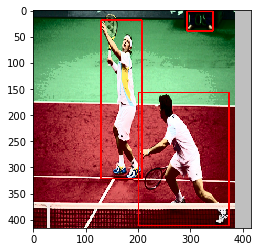

In [154]:
visualize(image_1,boxes1_)

In [155]:
x_coor = tx_vector[1,:].numpy()
y_coor = ty_vector[1,:].numpy()
w_coor = tw_vector[1,:].numpy()
h_coor = th_vector[1,:].numpy()

In [205]:
x_min,y_min,x_max,y_max =tf.split(boxes1_,4,axis=1)

#Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
width = x_max-x_min
height = y_max-y_min
x_global =x_min + (x_max - x_min)/2
y_global =y_min + (y_max - y_min)/2

print(x_global)
print(y_global)

tf.Tensor(
[[168.5552 ]
 [287.31903]
 [318.4109 ]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[170.11475]
 [284.29547]
 [ 20.69527]], shape=(3, 1), dtype=float32)


In [213]:
print(338/2)
print(416/13) #65

169.0
32.0


In [156]:
print(np.where(x_coor!=0))
print(np.where(y_coor!=0))

(array([141, 225, 429]),)
(array([141, 225, 429]),)


In [157]:
tx = x_coor[np.where(x_coor!=0)]
ty = y_coor[np.where(y_coor!=0)]
tw = w_coor[np.where(w_coor!=0)]
th = h_coor[np.where(h_coor!=0)]

In [158]:
th

array([ 0.09509907, -0.0796192 , -0.09379419], dtype=float32)

In [159]:
tw

array([-0.6367609,  0.1651282,  1.0113478], dtype=float32)

In [160]:
anchors =tf.constant(np.array([[0,0,0.015,0.037],[0,0,0.043,0.104],[0,0,0.11,0.278],[0,0,0.351,0.66]]),dtype=tf.float32).numpy()
which_anchor_box = anchors[[3,3,1],:]

print(which_anchor_box)
x_min_anchor,y_min_anchor,x_max_anchor,y_max_anchor =tf.split(which_anchor_box,4,axis=1)

width_anchor = x_max_anchor-x_min_anchor
height_anchor = y_max_anchor-y_min_anchor
x_global_anchor =x_min_anchor + (x_max_anchor - x_min_anchor)/2
y_global_anchor =y_min_anchor + (y_max_anchor - y_min_anchor)/2   

[[0.    0.    0.351 0.66 ]
 [0.    0.    0.351 0.66 ]
 [0.    0.    0.043 0.104]]


In [202]:
x_min,y_min,x_max,y_max =tf.split(boxes1_,4,axis=1)

#Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
width = x_max-x_min
height = y_max-y_min
x_global =x_min + (x_max - x_min)/2
y_global =y_min + (y_max - y_min)/2

grid_size=26
#porción de la imagen que hay en cada celda
pixel_per_grid = 1/grid_size
print(pixel_per_grid)

#Obtenemos la coordenada de la celda donde están los boundingboxes
offset_grid_x = x_global//pixel_per_grid
offset_grid_y = y_global//pixel_per_grid

0.038461538461538464


In [203]:
x_global = (offset_grid_x * pixel_per_grid) + (tf.math.sigmoid(tx)[:,tf.newaxis])
y_global = (offset_grid_y * pixel_per_grid) + (tf.math.sigmoid(ty)[:,tf.newaxis])

print((offset_grid_x * pixel_per_grid) )
print((offset_grid_y * pixel_per_grid))

print("factor width",tf.math.exp(tw))
print("factor height",tf.math.exp(th))
print("anchor width",width_anchor)
print("anchor Height",height_anchor)
w = width_anchor*(tf.math.exp(tw)[:,tf.newaxis])
h = height_anchor*(tf.math.exp(th)[:,tf.newaxis])

tf.Tensor(
[[168.53847]
 [287.3077 ]
 [318.3846 ]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[170.07693 ]
 [284.26926 ]
 [ 20.692308]], shape=(3, 1), dtype=float32)
factor width tf.Tensor([0.52900314 1.1795443  2.749304  ], shape=(3,), dtype=float32)
factor height tf.Tensor([1.0997678  0.92346793 0.9104701 ], shape=(3,), dtype=float32)
anchor width tf.Tensor(
[[0.351]
 [0.351]
 [0.043]], shape=(3, 1), dtype=float32)
anchor Height tf.Tensor(
[[0.66 ]
 [0.66 ]
 [0.104]], shape=(3, 1), dtype=float32)


In [195]:
print(x_global)

tf.Tensor(
[[168.55862]
 [287.37772]
 [318.4181 ]], shape=(3, 1), dtype=float32)


In [196]:
print(y_global)

tf.Tensor(
[[170.10068 ]
 [284.33295 ]
 [ 20.703468]], shape=(3, 1), dtype=float32)


In [197]:
print(w*416)

tf.Tensor(
[[ 77.24293]
 [172.23235]
 [ 49.17955]], shape=(3, 1), dtype=float32)


In [198]:
print(h*416)

tf.Tensor(
[[301.95227]
 [253.54736]
 [ 39.39058]], shape=(3, 1), dtype=float32)


In [108]:
width = x_max-x_min
height = y_max-y_min
x_global =x_min + tf.math.divide(x_max - x_min,2)
y_global =y_min + tf.math.divide(y_max - y_min,2)

In [22]:
i[2]

<tf.Tensor: shape=(2, 1690), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [190]:
parsed_image_dataset = raw_image_dataset.map(preprocessing,num_parallel_calls=8)#.map(tf_numpy_albumentations_real,num_parallel_calls=8)
for index,i in enumerate(parsed_image_dataset.batch(8).prefetch(8)):
    if index == 1000:
        good_batch = i
        break

In [226]:
def imgaug_data_augmentation(image,bboxes,num_real_boxes,policy):
    im_shape = image.shape
    bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes*416, shape=(416,416))
    
    #policy = np.random.randint(5)
    
    #policy = 2
    if policy == 0:
        
        p = np.random.random()
        if p<0.6:
            aug = iaa.TranslateX(px=(-60, 60),cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
        p = np.random.random()
        if p<0.8:
            aug = iaa.HistogramEqualization()
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
    elif policy==1:
        
        p=np.random.random()
        if p<0.2:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
        
        p=np.random.random()
        if p<0.8:
            square_size = np.random.randint(48)
            aug = iaa.Cutout(nb_iterations=1, size=square_size/416, squared=True)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
    elif policy==2:
        p=np.random.random()
        if p<=1:
            aug = iaa.ShearY(shear=(int(-0.06*416), int(0.06*416)), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
            
        p=np.random.random()
        if p<=1:
            aug = iaa.TranslateY(px=(int(-0.18*416), int(0.18*416)),cval=128)
            for i in bbs.to_xyxy_array(np.int32)[:num_real_boxes,:]:
                bbox = image[i[1]:i[3],i[0]:i[2]]
                bbox_augmented = aug(image=bbox)
                image[i[1]:i[3],i[0]:i[2]] = bbox_augmented
            
    elif policy==3:
        p=np.random.random()
        if p<=0.6:    
            aug = iaa.Rotate(rotate=(-30, 30), order=1, cval=128)
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs_aug.remove_out_of_image().clip_out_of_image()
        
        p=np.random.random()
        if p<=1:
            aug = iaa.MultiplySaturation((0.54, 1.54))
            image, bbs = aug(image=image, bounding_boxes=bbs)
            #bbs.remove_out_of_image().clip_out_of_image()
    
    else:
        image = image
        bb == bbs
        
        
    return image,bbs.to_xyxy_array(np.int32),num_real_boxes

In [227]:
which_image = 6

image = good_batch[0][which_image,:].numpy()
boxes = good_batch[1][which_image,:good_batch[2][which_image].numpy(),:].numpy()
print(boxes)

[[0.61492187 0.01760663 0.9646094  0.554692  ]
 [0.0204375  0.03116114 0.35770312 1.        ]]


0
1
2
3
4
5
1
6
7
8
9
10
2
11
12
13
14
15
3
16
17
18
19
20


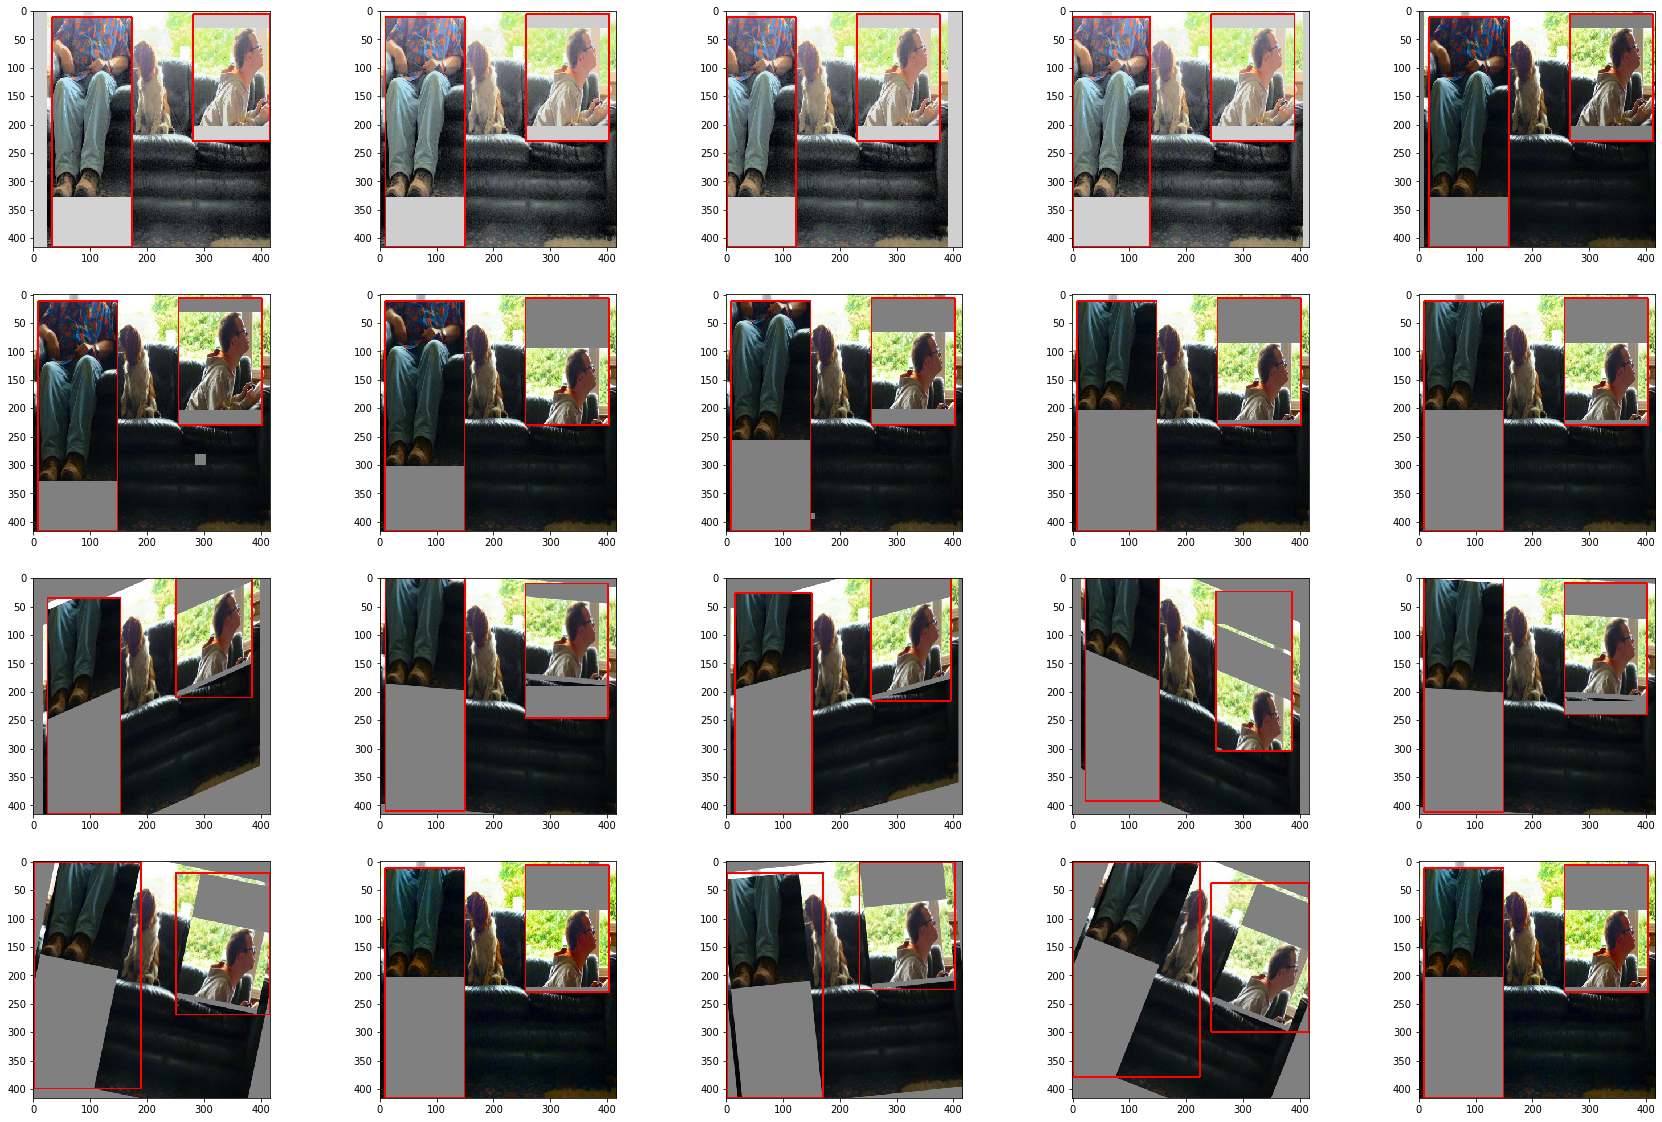

In [229]:
plt.figure(figsize=(30,20))
for policy in range(4):
    print(policy)
    for iteration in range(5):
        print((iteration+1)+(policy)*5)
        image_aug,boxes_aug,num_real_boxes = imgaug_data_augmentation(image,boxes,good_batch[2][3].numpy(),policy)
        plt.subplot(4,5,(iteration+1)+(policy)*5)
        boxes_aug = np.clip(boxes_aug,1,415)
        visualize(image_aug,boxes_aug)
        

In [221]:
imgaug_data_augmentation

<function __main__.imgaug_data_augmentation(image, bboxes, num_real_boxes, policy)>

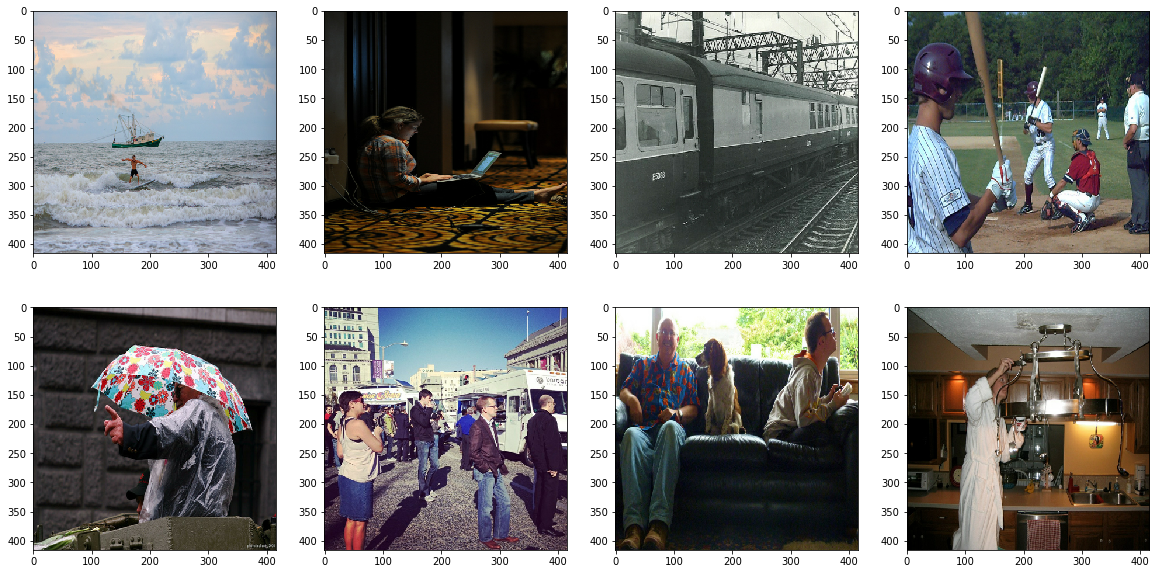

In [149]:
plt.figure(figsize=(20,10))
num_example = 2
    #plt.figure(figsize=(12, 12))
    #plt.imshow(img)
for i in range(8):
    plt.subplot(2,4,i+1)
    image = good_batch[0][i,:].numpy()
    boxes = np.clip(good_batch[1][i,:good_batch[2][i].numpy(),:].numpy(),1,415)
    visualize(image,boxes)

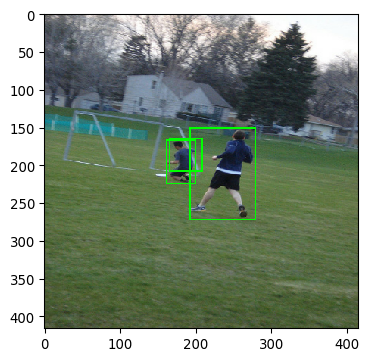

In [221]:
bbs = BoundingBoxesOnImage.from_xyxy_array(sample_boxes, shape=(416,416))
ia.imshow(bbs.draw_on_image(sample_image, size=2))

In [155]:
aug = iaa.TranslateX(px=(-20, 20),cval=128)
image_aug, bbs_aug = aug(image=sample_image, bounding_boxes=bbs)

In [156]:
bbs_aug.remove_out_of_image().clip_out_of_image().to_xyxy_array(np.int32)

array([[ 69, 197, 187, 359],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208],
       [161, 166, 203, 208]], dtype=int32)

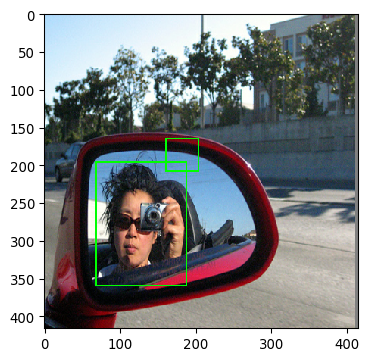

In [157]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [130]:
aug = iaa.HistogramEqualization()
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

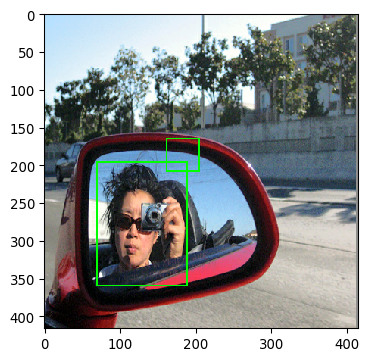

In [131]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [132]:
aug = iaa.Cutout(nb_iterations=1, size=0.15, squared=True)
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

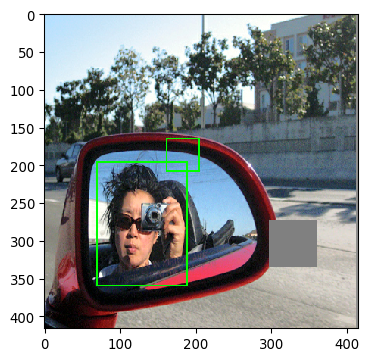

In [133]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [134]:
aug = iaa.ShearY(shear=(-50, 50), order=1, cval=128)
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

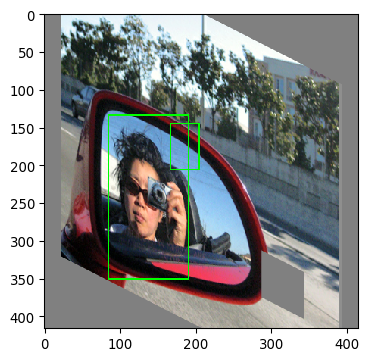

In [135]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [136]:
aug = iaa.Rotate(rotate=(-30, 30), order=1, cval=128)
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

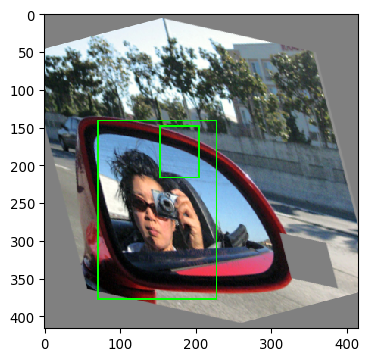

In [137]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [246]:
aug = iaa.MultiplySaturation((1.5, 1.5))
image_aug, bbs_aug = aug(image=image_aug, bounding_boxes=bbs_aug)

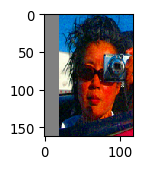

In [247]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

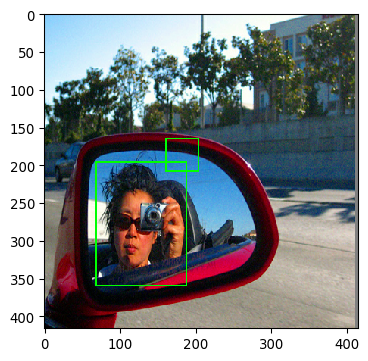

In [233]:
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [234]:
bbs_aug

BoundingBoxesOnImage([BoundingBox(x1=69.0480, y1=197.4613, x2=187.1920, y2=359.4240, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=208.0000, label=None), BoundingBox(x1=161.4000, y1=166.4000, x2=203.0000, y2=2

In [399]:
for i in parsed_image_dataset.batch(16):
    break

In [400]:
image_aug = i[0][2,:].numpy()
print(sample_image.shape)
boxes_aug = i[1][2,:].numpy()
print(sample_boxes.shape)

(416, 416, 3)
(20, 4)


In [401]:
bbs = BoundingBoxesOnImage.from_xyxy_array(boxes_aug[:2,:], shape=(416,416)).remove_out_of_image().clip_out_of_image()

In [402]:
'''
aug = iaa.TranslateY(px=(-50, 50),cval=128)
for i in bbs.to_xyxy_array(np.int32)[:2]:
    print(i)
    aux = image_aug[i[1]:i[3],i[0]:i[2]]
    print(aux.shape)
    image = aug(image=aux)
    print(image.shape)
    ia.imshow(image)
    image_aug[i[1]:i[3],i[0]:i[2]] = image
'''

'\naug = iaa.TranslateY(px=(-50, 50),cval=128)\nfor i in bbs.to_xyxy_array(np.int32)[:2]:\n    print(i)\n    aux = image_aug[i[1]:i[3],i[0]:i[2]]\n    print(aux.shape)\n    image = aug(image=aux)\n    print(image.shape)\n    ia.imshow(image)\n    image_aug[i[1]:i[3],i[0]:i[2]] = image\n'

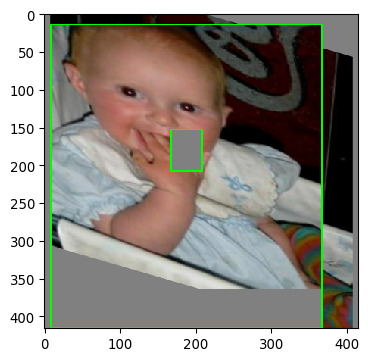

In [403]:
ia.imshow(bbs.draw_on_image(image_aug, size=2))

In [89]:
6%3

0